# Prediction - Store Sales

# 1.0 Overview

### 1.1 Overview

Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

reference: https://www.kaggle.com/competitions/rossmann-store-sales/data

### 1.1.2 CRISP - DS

CRoss-Industry Process - Data Science

- Development Cicle Method 
   - Do the same process many times to improve the prediction in each cicle.
   - In each end-to-end cicle have a version with the solution.
   - Velocity to delivery values.
   - Mapping all possibibles problems.
   

#### 1.1.2.1 CRISP Steps

1. Business questions - Try to solve problems with all areas and people.
2. Understand the Business - What's the poeple want? Normally the people give the solution, and we need to discover the "pain" of this person/business
3. Data Collect - From Databases, API, Files...
4. Data Clean - Keep a "stadard" data and remove dirty data, fillout NA's...
5. Data Exploration - What's the variable will impact the model(the result). Find the correlation between the fields.
6. Data Modeling - Prepare the data to put into the ML code (train and test, encoding, transform data, answer data...)
7. Apply ML 
8. Algoritimun Accuracy - Calculate the errors using ML's/Statistics (MAP, RME, MAPE, RMSE, ROCK, ACCURACY, TRUE TABLE...)

After the step 8º you and the team can see that the accuracy of the FIRST model will impact well the solution (normally not happen after the first cicle), we can put the MODEL in production, if not, start the other CICLE in STEP 2.

**IMPORTANT** you not back on the step 1 because the problem will be YOU, and we need to decide and change the steps 2º to 8º.

#### 1.1.2.2 Business Questions

What's the sales value of each store in the next 6 weeks?

#### 1.1.2.3 Understand the Business

- **What's the motivation to do this?** CFO (Chief Financial Officer) has requested the prediction of sales at the monthly meeting about the stores results.
- **What's the main cause of the problem?** Difficult to understand the value of investment to renovate each store.
- **Who is the stakeholder of the problem?** Director Finance (CFO) of Rossmann
- **What's the solution/product format that will be delivered?**
    - Granularity: Prediction sell per day and store on the next 42 days (6 weeks).
    - Problem type: Forecast sell .
    - Potencials Methods: Temporal series, regression with modifications.
    - Product/solution format: Check on the phone the total salles in each store on the final of the 6 weeks

# 2.0 IMPORTS

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot  as plt

import inflection
import math


from IPython.display         import HTML

# 3.0 Data clean

- **Why Data Description?**
    - **How challenger is the problem im working?**
    - **What's the duration of this problem?**
        - Years?
        - Months?
        - Days?
    - **What's the quantity of the data?**
        - I have the enought resourcing to work?
            - I need servers to process the data?
            - Clusters?
            - Spark?
            - Hadoop?
    - **What's the variable types (will help to decide the techniques to apply):**
        - % Numeric?
        - % Categories?
        - % Temporal?
    - **What's the NA(non-applicable/empty) data?**
        - NA's volume
        - What's the reazon of this NA's? 
            - I can do the job?
            - How I will reaplace the data?
            - I can replace or delete the data?
            - **details** sometimes the system isn't recording the data, the input is manually.
    - **Data summary:**
        - Describe stats.
        - Get the limits, minimum, maximun, STD, mean...
        
    

### 3.0.1 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )

    sns.set()
    
jupyter_settings()

### 3.0.2 Loading Data

In [3]:
df_sales_raw = pd.read_csv( '../data/train.csv', low_memory=False )
df_store_raw = pd.read_csv( '../data/store.csv', low_memory=False )

# Merge the both raw data
# merge(reference_table, merged_table, type of merge, column key equal in both tables )
df_raw = pd.merge(df_sales_raw, df_store_raw, how="left", on="Store")

In [4]:
#Sample of sales data
df_sales_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
831652,648,7,2013-06-16,0,0,0,0,0,0


In [5]:
#Sample of store data
df_store_raw.sample()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
530,531,a,c,4030.0,NaN,NaN,0,NaN,NaN,NaN


In [6]:
#Sample of sales data
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
772476,567,4,2013-08-08,4355,602,1,0,0,1,c,a,1010.0,9.0,2012.0,1,18.0,2011.0,"Feb,May,Aug,Nov"


## 3.1 DATA DESCRIPTION

#### 3.1.1 Rename Columns

In [7]:
#Copy to keep the raw data.
df1 = df_raw.copy()

In [8]:
#Show the columns name
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [9]:
cols_old_names = df1.columns

#Create a function using the inflection library with undersocore method to puth _ between the name of the columns
snakecase = lambda x: inflection.underscore(x)

#Create a list with new columns name
cols_new_name = list(map(snakecase, cols_old_names))

#replace the old to new columns names
df1.columns = cols_new_name

#Show the new names
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

#### 3.1.2 Data Dimensions

In [10]:
#Total rows and columns
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Columns: 18


#### 3.1.3 Data Types

In [11]:
#Show the data type for each column
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [12]:
#Change the date object to datetime type
df1['date'] = pd.to_datetime( df1['date'] )

#### 3.1.4 Check NA's

In [13]:
#Check the NA's total has in each line
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

**important** We have three possibilities to management the NA's
  1. Discard the row that contain NA's (delete)
  2. Use the mean, median, or ML methods.
  3. Use the business questions to decide how we can replace.

##### 3.1.4.1 Fillout NA's

In [14]:
#CompetitionDistance - distance in meters to the nearest competitor store
#decision: Assuming two hypotheses, or the store doesn't have competition or the competitor store is very far.
#action: Fillout the NA's with a big distance to assuming these stores doesn't have a competition.
# df1['competition_distance'].max() = 75860.0

df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )


#CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
#decision: Assuming these hypotheses, or the store doesn't open yet or the store opened before our store or we didn't record when the competitor store was open.
#action: Fillout the NA's with the same sale date of the same row.

df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1)
df1['competition_open_since_year']  = df1.apply(lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1)


#Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
#Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
#decision: Assuming the store doesn't want to participate of the promo2 .
#action: Fillout the NA's with the same sale date of the same row.

df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1)
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1)

#PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store#decision: Assuming the store doesn't want to participate of the promo2 .
#decision: Getting the month of the date sale and replace number to prefix month later fillna to 0 and cheching if this month is into the promo_interval, if yes set 1 else 0
#action: Fillout the NA's with the same sale date of the same row.

#Create the month_map
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

#Fillna = 0, implace is not show the message/question
df1['promo_interval'].fillna(0, inplace=True)

#Create a column to see the months in "prefix" name
#get the DATE columns, transform in DATE(dt), get the month (month), and map(map) all data using the variable month_map
df1['month_map'] = df1['date'].dt.month.map( month_map )

#First condition: Split the promo_terval in comma, and check if df1['month_map'] is in on df1['promo_interval'], if yes 1 else 0
# 1 = The store is participating of the promo
# 0 = The store is not participating of the promo

#Second condition: If df1['promo_interval'] = 0 means that the store wasn't participating of the consecutive promotion
df1['ispromo'] = df1[['promo_interval','month_map']].apply (lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1)
 

In [15]:
df1.sample(5).T

,830495,887307,438539,20258,255078
store,606,553,15,189,1114
day_of_week,1,6,2,1,5
date,2013-06-17 00:00:00,2013-04-27 00:00:00,2014-06-03 00:00:00,2015-07-13 00:00:00,2014-12-12 00:00:00
sales,8459,10103,7805,12550,19390
customers,831,971,720,1021,3126
open,1,1,1,1,1
promo,1,0,1,1,0
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,a,c,d,d,a


##### 3.1.4.5 Change Types

In [16]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
ispromo                                  int64
dtype: object

In [17]:
#Change types to INT
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( 'int64' )
df1['competition_open_since_year']  = df1['competition_open_since_year'].astype( 'int64' )
df1['promo2_since_week']            = df1['promo2_since_week'].astype( 'int64' )
df1['promo2_since_year']            = df1['promo2_since_year'].astype( 'int64' )


##### 3.1.4.6 Descriptive Statistical

- **Central Tendency** One number to explain all = mean, median 
- **Dispersion** Check the spaces/dispersion between the central tendency of the other numbers (near or far of the mean/meadian) = std, min, max, range, skew, kurtosis 
    - Skew = Deformation on the normal distribuition
      - Left Skew = positive
      - right Skew = negative
    - Kurtosis = How the data is concentrate
        - Big Kurtosis = positive numbers
        - Small Kurtosis = negative numbers

In [18]:
#Separate the variables in two groups: numerics and categoric

num_attributes = df1.select_dtypes( include=['int64','float64'])
cat_attributes = df1.select_dtypes( exclude=['int64','float64','datetime64[ns]'])


In [19]:
num_attributes.sample(5)

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,ispromo
455574,325,1,7876,747,1,1,0,350.0,3,2011,1,22,2011,1
526623,14,7,0,0,0,0,0,1300.0,3,2014,1,40,2011,0
255834,906,4,8541,1044,1,0,0,90.0,7,2010,0,50,2014,0
177834,550,7,0,0,0,0,0,50.0,6,2015,0,8,2015,0
643249,680,1,8762,1198,1,1,0,170.0,12,2013,1,35,2012,1


In [20]:
cat_attributes.sample(5)


,state_holiday,store_type,assortment,promo_interval,month_map
146620,0,d,c,0,Mar
469375,0,d,c,"Mar,Jun,Sept,Dec",May
951884,0,a,a,0,Feb
421742,a,a,c,"Mar,Jun,Sept,Dec",Jun
463583,0,d,c,0,May


###### 3.1.4.6.1 Numerical Attributes

In [21]:
#Central Tendency = mean, median 
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

#Dispersion = std, min, max, range, skew, kurtosis 

d1 = pd.DataFrame (num_attributes.apply( np.std )).T
d2 = pd.DataFrame (num_attributes.apply( min )).T
d3 = pd.DataFrame (num_attributes.apply( max )).T
d4 = pd.DataFrame (num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame (num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame (num_attributes.apply( lambda x: x.kurtosis() )).T

#concatenate

m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['Attributes', 'Min', 'Max', 'Range', 'Mean', 'Median', 'STD', 'Skew', 'Kurtosis' ]
m

,Attributes,Min,Max,Range,Mean,Median,STD,Skew,Kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


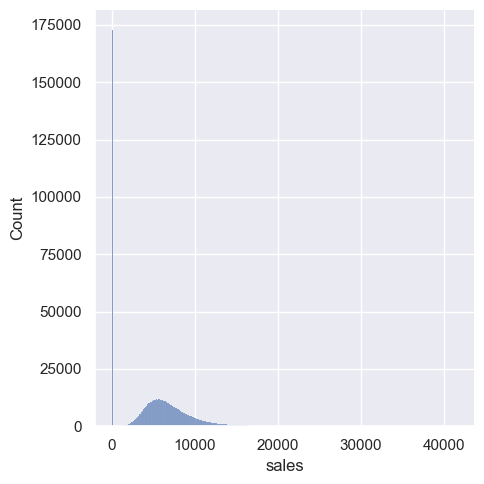

In [22]:
#Graph example
sns.displot(df1['sales'])

###### 3.1.4.6.2 Categorical Attributes

In [23]:
#Total unique values 
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

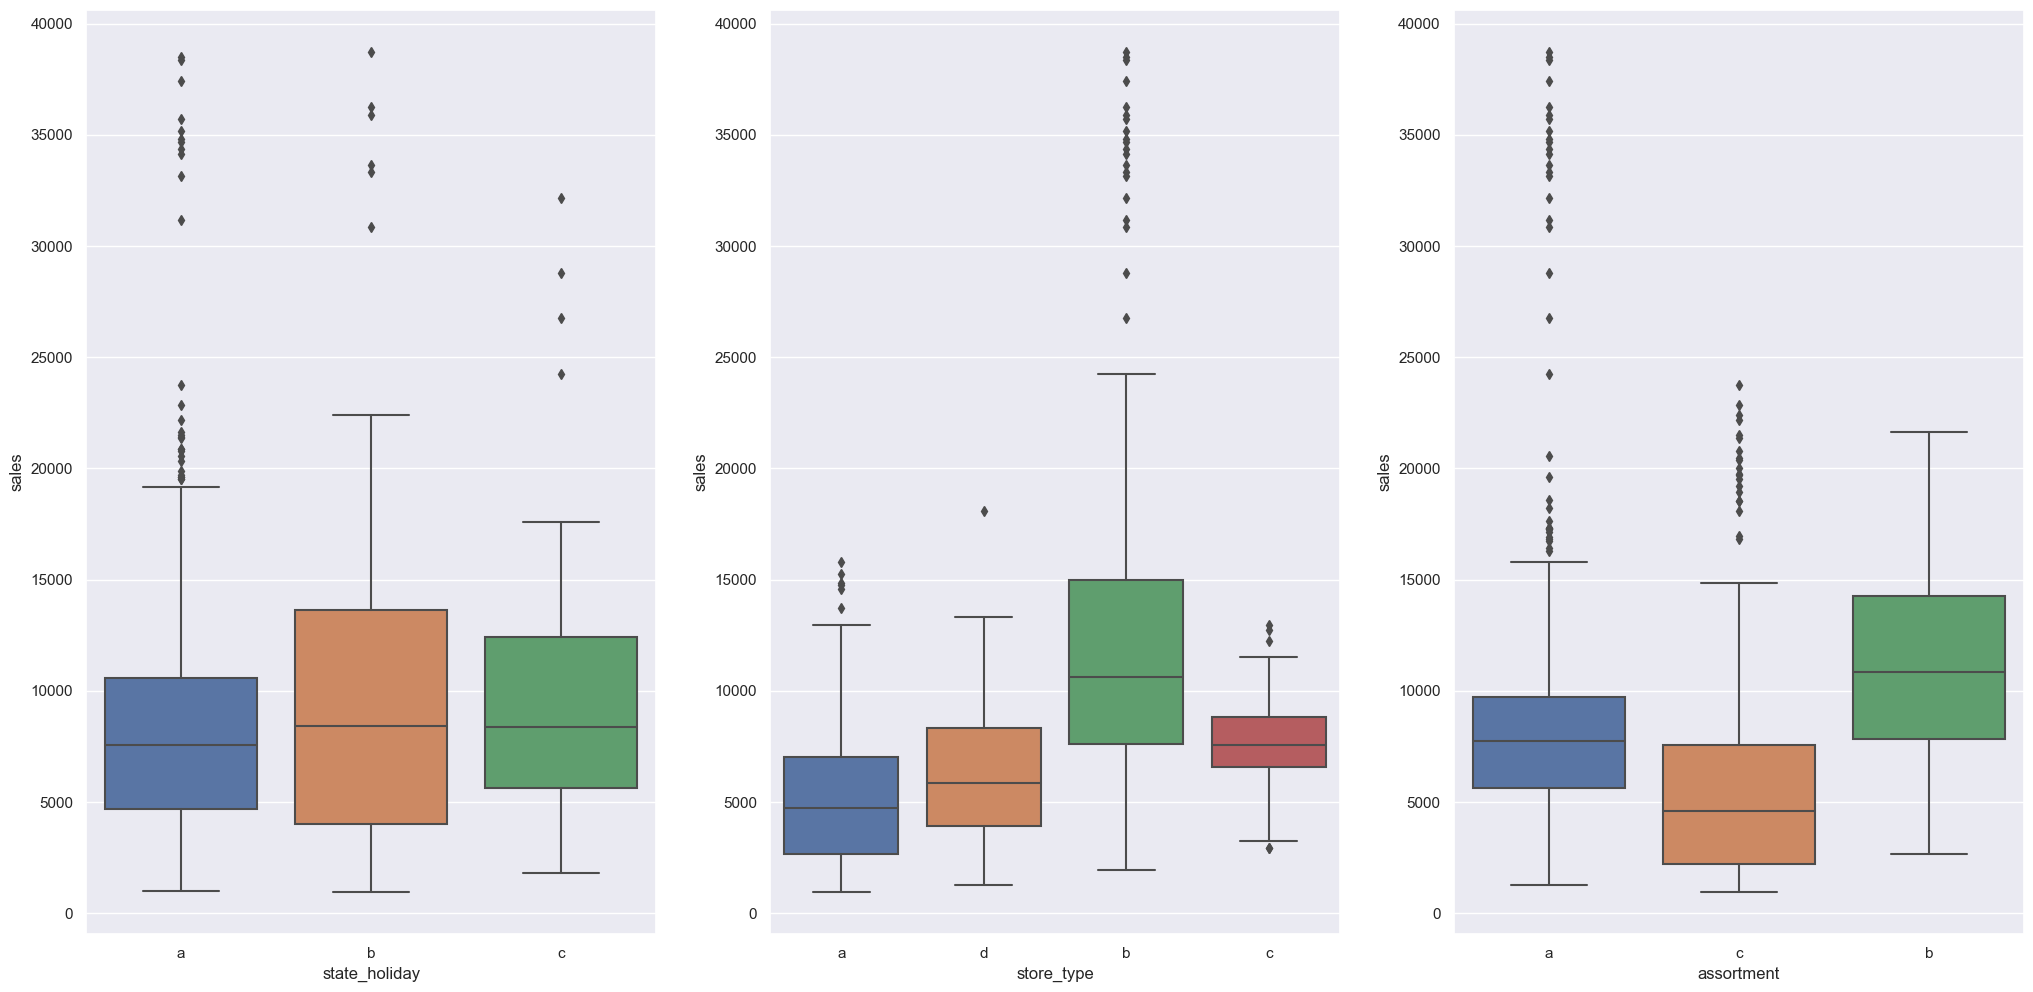

In [25]:
#Remove the closed stores and no sales
aux1 = df1[ (df1['state_holiday'] != '0') & (df1['sales'] > 0) ]

#1 rows, 3 columns, 1st position
plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

#1 rows, 3 columns, 2nd position
plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=aux1)

#1 rows, 3 columns, 3th position
plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux1)


##important##
#Outliers = 3x STD